# **Implementation of Autoencoder using Artificial Neural Networks (ANN) and Convolutional Neural Networks (CNN) on MNIST dataset**

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Dataset download

In [2]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset = mnist_data, batch_size = 64, num_workers=4, shuffle = True)

In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# Defining the Encoder and Decoder for Autoencoder using ANN

In [4]:
class AutoEncoder_ANN(nn.Module):
  def __init__(self):
    super().__init__()
    # in linear NN, we will have input images size as 28x28 = 784 inputs

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),   # syntax is nn.Linear(input_size, output_size)
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3)    # output will be 3 neurons
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12),   
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid()    # last layer output is 28*28
    )
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining the loss function and optimizer

In [6]:
ANN_model = AutoEncoder_ANN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ANN_model.parameters(), lr = 1e-3, weight_decay=1e-5)

ANN_model.to(device)

AutoEncoder_ANN(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [7]:
# just for checking
for img, _ in data_loader:
  print(img.shape)
  img1 = img.reshape(-1, 28*28)
  print(img1.shape)
  break


torch.Size([64, 1, 28, 28])
torch.Size([64, 784])


# Training loop for ANN

In [8]:
num_epochs = 10
outputs_ANN = []

for epoch in range(num_epochs):
  for img, _ in data_loader:
    img = img.to(device).reshape(-1, 28*28)
    # img = img.reshape(-1, 28*28)
    recon = ANN_model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
  outputs_ANN.append((epoch, img, recon))

Epoch: 1, Loss: 0.0558
Epoch: 2, Loss: 0.0436
Epoch: 3, Loss: 0.0384
Epoch: 4, Loss: 0.0352
Epoch: 5, Loss: 0.0366
Epoch: 6, Loss: 0.0385
Epoch: 7, Loss: 0.0422
Epoch: 8, Loss: 0.0356
Epoch: 9, Loss: 0.0389
Epoch: 10, Loss: 0.0362


# Plotting the images generated using Autoencoder of ANN

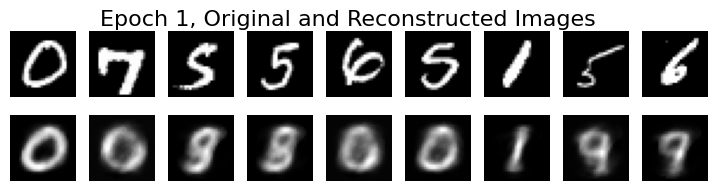

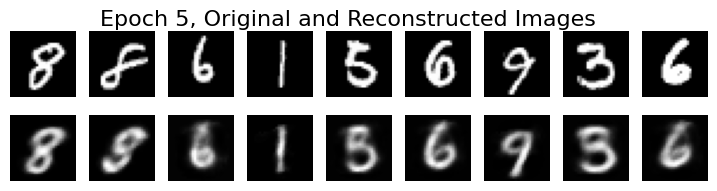

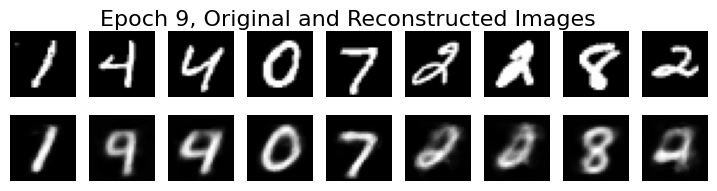

In [9]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs_ANN[k][1].detach().cpu().numpy()
    recon = outputs_ANN[k][2].detach().cpu().numpy()

    plt.suptitle(f'Epoch {k+1}, Original and Reconstructed Images', fontsize=16)
    
    for i, item in enumerate(imgs):
        if i>=9:
          break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28, 28)
        # print(item.shape)
        # print(item[0])
        # break
        plt.imshow(item[0])
        # print("after imshow")
        plt.axis('off')  

    # print("images done")
    
    for i, item in enumerate(recon):
        if i>=9:
          break
        plt.subplot(2, 9, 9+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
        plt.axis('off')  


# Defining the Encoder and Decoder for Autoencoder using CNN

In [10]:
class AutoEncoder_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # in CNN, we will have input images size as Nx1x28x28

    self.encoder = nn.Sequential(
        
        nn.Conv2d(1, 16, 3, stride=2, padding=1),  # Nx16x14x14
        nn.ReLU(),
        
        nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Nx32x7x7
        nn.ReLU(),
        
        nn.Conv2d(32, 64, 7),  # output Nx64x1x1 ie a scalar with 64 channels
   )

    self.decoder = nn.Sequential(

        nn.ConvTranspose2d(64, 32, 7), # Nx32x7x7
        nn.ReLU(),
        
        # nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1) # output will Nx16x13x13, 
        # but we need Nx16x14x14
        # so we will use output_padding
        
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # Nx16x14x14
        nn.ReLU(),

        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # Nx1x28x28
        nn.Sigmoid()
    )
  
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Defining the loss function and optimizer

In [11]:
CNN_model = AutoEncoder_CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 1e-3, weight_decay=1e-5)

CNN_model.to(device)

AutoEncoder_CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

# Training loop for CNN

In [12]:
num_epochs = 10
outputs_CNN = []

for epoch in range(num_epochs):
  for img, _ in data_loader:
    # img = img.to(device).reshape(-1, 28*28)
    img = img.to(device)
    # img = img.reshape(-1, 28*28)
    recon = CNN_model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
  outputs_CNN.append((epoch, img, recon))

Epoch: 1, Loss: 0.0090
Epoch: 2, Loss: 0.0057
Epoch: 3, Loss: 0.0046
Epoch: 4, Loss: 0.0044
Epoch: 5, Loss: 0.0027
Epoch: 6, Loss: 0.0033
Epoch: 7, Loss: 0.0027
Epoch: 8, Loss: 0.0027
Epoch: 9, Loss: 0.0029
Epoch: 10, Loss: 0.0028


# Plotting the images generated using Autoencoder of CNN

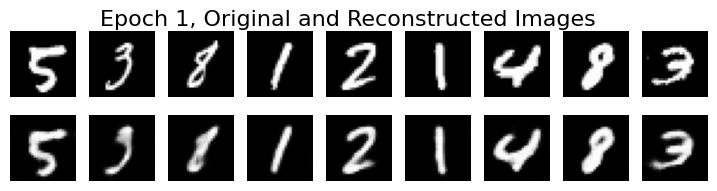

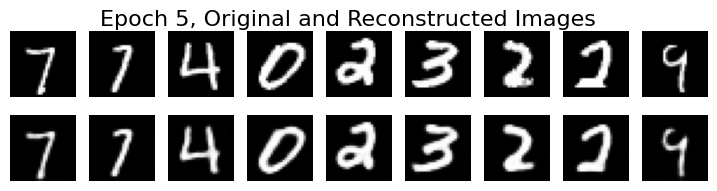

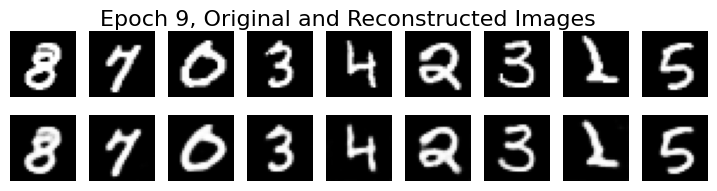

In [13]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9,2))
    plt.gray()
    imgs = outputs_CNN[k][1].detach().cpu().numpy()
    recon = outputs_CNN[k][2].detach().cpu().numpy()

    plt.suptitle(f'Epoch {k+1}, Original and Reconstructed Images', fontsize=16)

    for i, item in enumerate(imgs):
        if i>=9:
          break
        # print("what")
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28, 28)
        # print(item.shape)
        # print(item[0])
        # break
        plt.imshow(item[0])
        # print("after imshow")
        plt.axis('off')  

    # print("images done")
    
    for i, item in enumerate(recon):
        if i>=9:
          break
        plt.subplot(2, 9, 9+i+1)
        # item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
        plt.axis('off')  


# **Observations**
### From the images generated by the Autoencoder, we can observe that those produced using CNNs are better than those produced by ANNs.